In [10]:
import numpy as np
import nestle
import corner
import matplotlib.pyplot as plt

In [11]:
from settings import lightcurve_dir, config_dir, template_dir
from lightcurve import LightCurve, Outburst, read_template
from utils import read_outburst_numbers, read_priors
import NoSpin_py as nospin

In [12]:
outburst_numbers = read_outburst_numbers(filename=config_dir+'outburst_numbers.txt')

In [13]:
lightcurve_detections_file = lightcurve_dir + "OJ287_Vmag.txt"
lightcurve_nondetections_file = lightcurve_dir + "OJ287_Vmag_upper.txt"

lightcurve_detections = LightCurve(lightcurve_detections_file)
lightcurve_nondetections = LightCurve(lightcurve_nondetections_file, Mref=lightcurve_detections.Mref)

In [14]:
cuts = np.genfromtxt(config_dir+"lightcurve_cuts.txt")

In [15]:
labels = [int(cut_min) for cut_min,cut_max in cuts]

In [16]:
priors = read_priors(config_dir+"priors.txt")

In [17]:
templates_rr = [read_template(template_dir+"oj287_templ_{}.txt".format(label)) for label in labels]

In [18]:
outbursts_rr = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, template, label=label) for cut,prior,template,label in zip(cuts,priors,templates_rr,labels)]

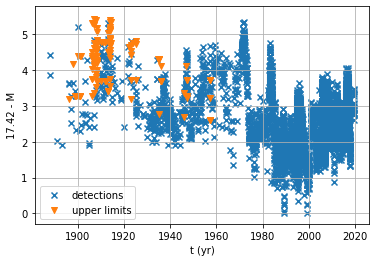

In [20]:
# Figure 1

def plot_full_lightcurve(lightcurve_det, lightcurve_cen):
    plt.scatter(lightcurve_det.t, lightcurve_det.M, marker='x', label="detections")
    plt.scatter(lightcurve_cen.t, lightcurve_cen.M, marker='v', label='upper limits')
    plt.xlabel("t (yr)")
    plt.ylabel("{} - M".format(lightcurve_det.Mref))
    plt.legend()
    plt.grid()
    plt.show()

plot_full_lightcurve(lightcurve_detections, lightcurve_nondetections)

In [22]:
# Table 2

for ob in outbursts_rr:
    print(ob.nob, ob.year, len(ob.lightcurve_det.t), len(ob.lightcurve_cen.t))

5 1912 10 2
8 1934 13 0
11 1947 12 3
12 1957 7 5
14 1964 5 0
16 1972 17 0
17 1982 35 0
18 1984 35 0
20 1995 22 0
21 2005 53 0
22 2007 18 0
23 2015 131 0
24 2019 15 0


In [13]:
param_labels = ["$t_{ob}$ (yr)", "$\\Delta M$", "$s$", "$A$", "$\\varsigma$"]

In [14]:
def maxlike(result):
    idx = np.argmax(result.logl)
    return result.samples[idx]

In [15]:
def plot_fit(outburst, params):
    plt.scatter(outburst.lightcurve_det.t, outburst.lightcurve_det.M)
    plt.scatter(outburst.lightcurve_cen.t, outburst.lightcurve_cen.M)
    tmpl_to_obs = outburst.templ_to_obs(params)
    plt.plot(tmpl_to_obs.t, tmpl_to_obs.M)
    plt.axvline(params[0])

In [23]:
years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()
for ob, bw in zip(outbursts_rr, bandwidths):
    ob.run_sampler()
    ob.process_samples(bw)
    #ob.save_samples("1tmpl/oj287_tobs_samples_{}.txt".format(ob.year))
    #ob.save_kde("1tmpl/oj287_tobs_kde_{}.txt".format(ob.year))

Running sampler for year 1912


/home/abhimanyu/.local/lib/python3.6/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


Running sampler for year 1934
Running sampler for year 1947
Running sampler for year 1957
Running sampler for year 1964
Running sampler for year 1972
Running sampler for year 1982
Running sampler for year 1984
Running sampler for year 1995
Running sampler for year 2005
Running sampler for year 2007
Running sampler for year 2015
Running sampler for year 2019


1912.999512891189
1934.140118615647
1947.1882328869237
1957.1166220996768
1964.2316396267886
1972.9504557172972
1982.9930602222018
1984.1456441212597
1995.8400283411122
2005.7775352992855
2007.690977497746
2015.8983568168962
2019.5661187779847


(-0.1655, 1.1655, -0.1655, 1.1655)

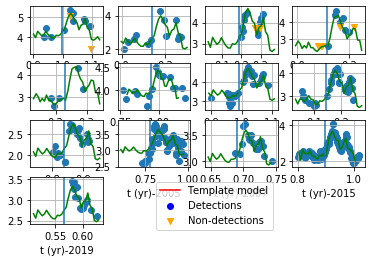

In [33]:
# Add a new figure if needed.

for idx,ob in enumerate(outbursts_rr):
    res = ob.result
    
    tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)[0]
    dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)[0]
    s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)[0]
    A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)[0]
    
    print(tob)
    
    yr = ob.year
    
    plt.subplot(4,4,idx+1)
    model = ob.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t-yr, model.M, color='red')
    plt.scatter(ob.lightcurve_det.t-yr, ob.lightcurve_det.M)
    plt.scatter(ob.lightcurve_cen.t-yr, ob.lightcurve_cen.M, color='orange', marker='v')
    plt.axvline(tob-yr, color='red')
    plt.grid()
    plt.xlabel("t (yr)-{}".format(yr), fontsize='12')
    plt.tick_params(labelsize=11)
    
plt.subplot(4,4,15)
plt.scatter([],[],color='blue',label="Detections")
plt.scatter([],[],color='orange',marker="v",label="Non-detections")
plt.plot([],[],color='red',ls="-",label="Template model")
plt.legend()
plt.axis('off')

5 1912.9995 0.0079
8 1934.1401 0.0054
11 1947.1882 0.0043
12 1957.1166 0.0071
14 1964.2318 0.0222
16 1972.9504 0.0091
17 1982.9931 0.0013
18 1984.1456 0.0023
20 1995.8400 0.0075
21 2005.7775 0.0065
22 2007.6910 0.0013
23 2015.8984 0.0008
24 2019.5661 0.0024


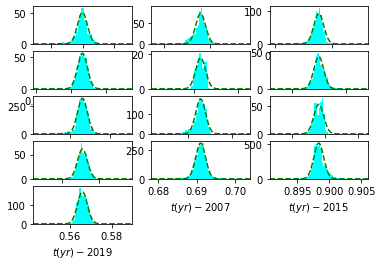

In [36]:
# Table 3
# Figure 5(a)

years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()

for idx,(ob,bw) in enumerate(zip(outbursts_rr,bandwidths)):
    ob.process_samples(bw)
    
    tob_med = corner.quantile(ob.result.samples[:,0], 0.5, weights=ob.result.weights)[0]
    samples = nestle.resample_equal(ob.result.samples[:,0], weights=ob.result.weights)
    
    samples_d = samples - ob.year
    median = np.median(samples_d)
    mad = np.median(np.abs(samples_d-median))
    std = 1.4826*mad
    print("{:d} {:0.4f} {:0.4f}".format(ob.nob, median+ob.year, std))
    
    plt.subplot(5,3,idx+1)
    
    left,right = median-10*std, median+10*std 
    plt.hist(samples_d, bins=64, density=True, color='cyan', range=[left,right])
    
    grid = np.linspace(left, right, 10000)
    #pdf_kde = ob.kde.predict(grid[:,np.newaxis]+ob.year)
    #plt.plot(grid, pdf_kde, color='r', label="KDE ({})".format(int(ob.year)))
      
    pdf_gauss = 1/np.sqrt(2*np.pi)/std * np.exp(-0.5*((grid-median)/std)**2)
    plt.plot(grid, pdf_gauss, color='green', label="KDE ({})".format(int(ob.year)), ls='--')
    
    plt.xlim([left,right])
    
    plt.xlabel("$t (yr)-{}$".format(ob.year))

    #kde_save = np.array([grid+ob.year, np.log(pdf_kde)]).transpose()
    #np.savetxt("1tmpl/oj287_tobs_samples_{}.txt".format(ob.year), samples)
    #np.savetxt("1tmpl/oj287_tobs_kde_{}.txt".format(ob.year), kde_save)

In [37]:
z = 0.306
year = 365.25*24*3600

In [39]:
phiobs = np.pi*np.array([ob.nob for ob in outbursts_rr])
tobs = np.array([ob.median for ob in outbursts_rr])
toberrs = np.array([ob.nmad for ob in outbursts_rr])
lnlike_gauss = nospin.Likelihood(phiobs, tobs*year, toberrs*year, z)

In [40]:
def prior_transform_fn(datafile, nparams):
    units, prmin, prmax = np.genfromtxt(datafile)
    prmin *= units
    prmax *= units
    spans = prmax-prmin
    def prior_transform(cube):
        return prmin + spans*cube

    if len(prmin) != nparams:
        raise ValueError()
    
    return prior_transform

In [44]:
prior_transform = prior_transform_fn("../../data/config/nospin_priors_Bg.txt", nospin.N_PARAMS)

gauss_result = nestle.sample(lnlike_gauss, prior_transform, nospin.N_PARAMS, npoints=300, method='multi', 
                             callback=nestle.print_progress, )

it=  8265 logz=-362.8694452813447

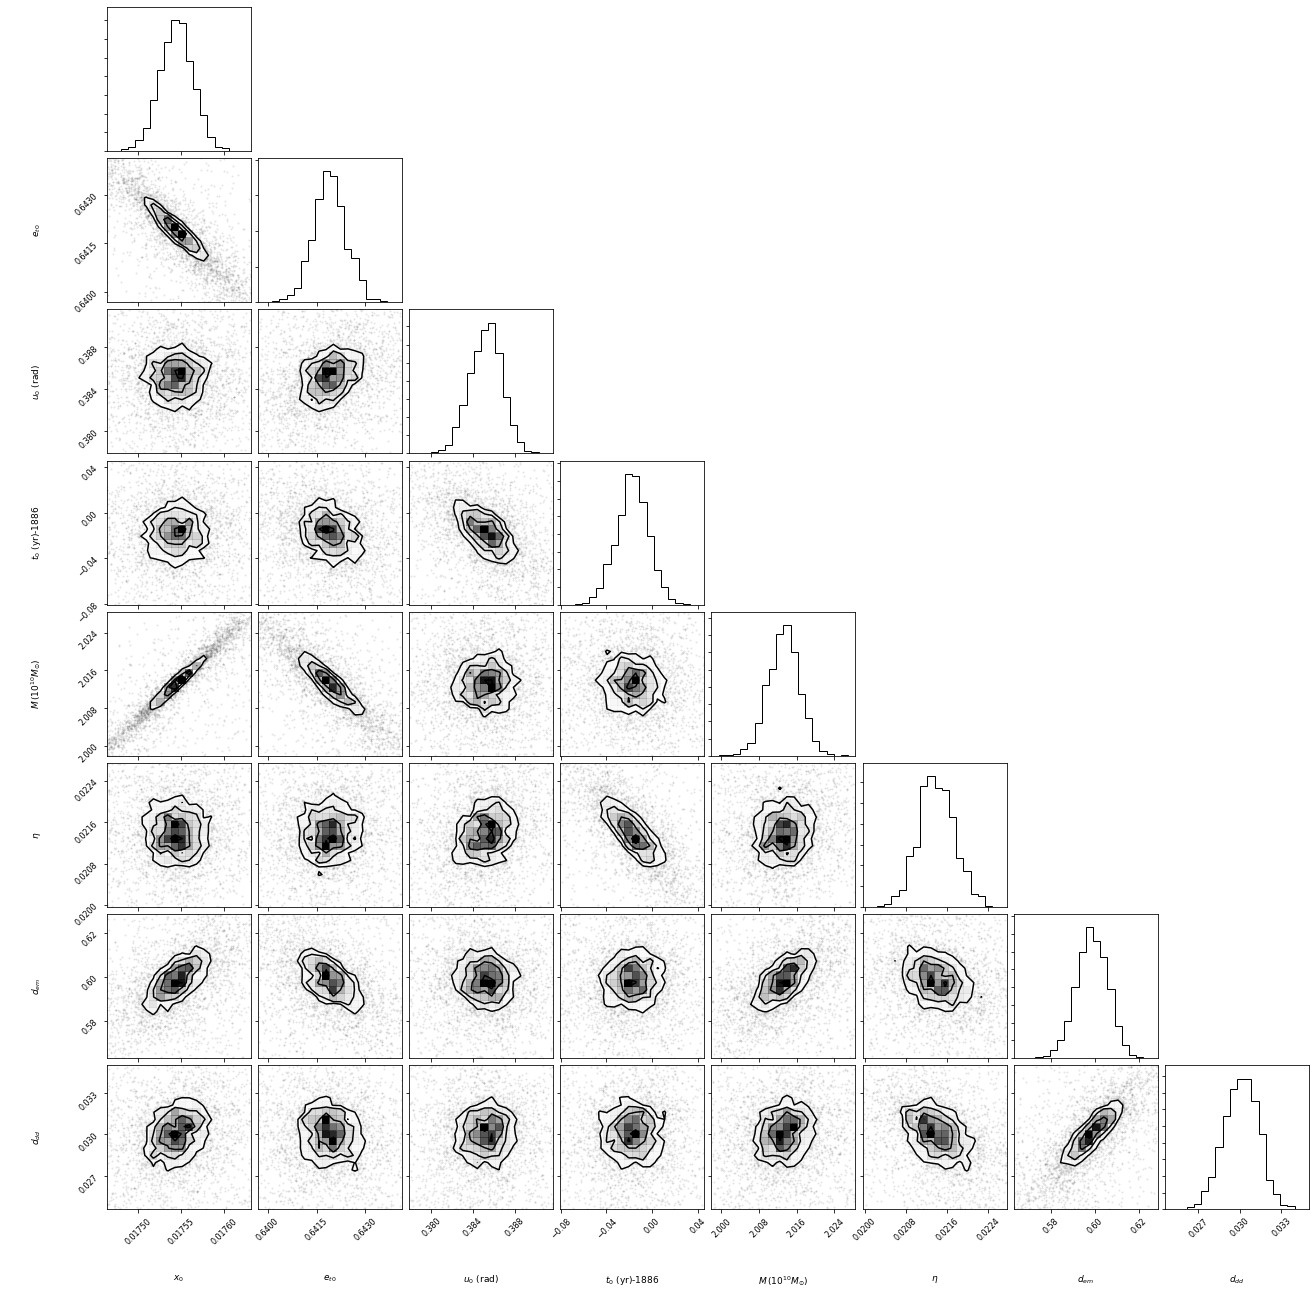

In [46]:
MSun = 4.92703806e-6
samples = gauss_result.samples.copy()
samples[:,3] /= year
samples[:,3] -= 1886
samples[:,4] /= MSun*1e10

nospin_labels = ["$x_0$", "$e_{t0}$", "$u_{0}$ (rad)", "$t_{0}$ (yr)-1886", "$M\\,(10^{10}M_{\\odot})$", "$\\eta$", 
                 "$d_{em}$", "$d_{dd}$"]
nospin_labels = ['\n\n'+l+'\n\n' for l in nospin_labels]
 
postfig = corner.corner(samples, weights=gauss_result.weights, range=[0.99999]*nospin.N_PARAMS, labels=nospin_labels, 
                        label_kwargs={"fontsize":9}, max_n_ticks=4)

for ax in postfig.get_axes():
    ax.tick_params(axis='both', labelsize=8)

(8466, 4)
(8466,)


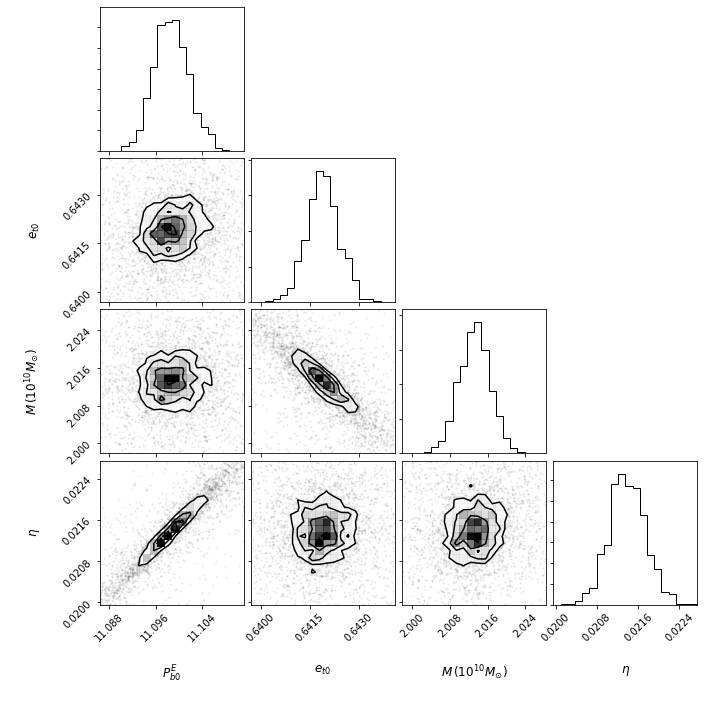

In [56]:
MSun = 4.92703806e-6

Msamples = gauss_result.samples[:,4]
x0samples = gauss_result.samples[:,0]
nb0samples = x0samples**1.5 / Msamples
Pb0E_year_samples = (1+z)*2*np.pi/nb0samples/year
e0samples = gauss_result.samples[:,1]
etasamples = gauss_result.samples[:,5]

nospin_labels = ["$P_{b0}^E$", "$e_{t0}$", "$M\\,(10^{10}M_{\\odot})$", "$\\eta$"]
nospin_labels = ['\n'+l+'\n' for l in nospin_labels]
 
samples = np.transpose([Pb0E_year_samples, e0samples, Msamples/(MSun*1e10), etasamples])
print(samples.shape)
print(gauss_result.weights.shape)
    
postfig = corner.corner(samples, weights=gauss_result.weights, range=[0.99999]*4, labels=nospin_labels, 
                        label_kwargs={"fontsize":12}, max_n_ticks=4)

#for ax in postfig.get_axes():
#    ax.tick_params(axis='both', labelsize=8)

In [64]:
def median_nmad(samples, weights):
    median = corner.quantile(samples, 0.5, weights=weights)[0]
    absdev = np.abs( samples - median )
    nmad = corner.quantile(absdev, 0.5, weights=weights)[0] / 0.6744897501960817
    return median, nmad

In [68]:
import uncertainties

MSun = 4.92703806e-6
samples = gauss_result.samples.copy()
samples[:,3] /= year
#samples[:,3] -= 1886
samples[:,4] /= MSun*1e10

nospin_labels = ["x0", "et0", "u0", "t0", "M", "eta", "dem", "ddd"]
 
for idx, lbl in enumerate(nospin_labels):
    smpl = samples[:,idx]
    med, nmad = median_nmad(smpl, gauss_result.weights)
    val = uncertainties.ufloat(med, nmad)
    print(lbl, "{:+.1uS}".format(val))

x0 +0.01755(2)
et0 +0.6419(5)
u0 +0.385(2)
t0 +1885.98(1)
M +2.013(3)
eta +0.0214(3)
dem +0.598(7)
ddd +0.030(1)


In [70]:
x0_samples = gauss_result.samples[:,0]
M_samples = gauss_result.samples[:,4]
nb0_samples = x0_samples**1.5 / M_samples
Pb0E_year_samples = (1+z)*2*np.pi/nb0_samples/year

med, nmad = median_nmad(Pb0E_year_samples, gauss_result.weights)
val = uncertainties.ufloat(med, nmad)
print("Pb0E", "{:+.1uS}".format(val))

ddd +11.099(3)


In [73]:
def aop_k(x, e, eta):
    return (-3*x)/(-1 + e**2) + ((54 + e**2*(51 - 26*eta) - 28*eta)*x**2)/(4.*(-1 + e**2)**2) + ((-16*e**4*(156 + 5*eta*(-22 + 13*eta)) + e**2*(-96*(191 + 40*np.sqrt(1 - e**2)) + eta*(64*(357 + 24*np.sqrt(1 - e**2) - 80*eta) - 123*np.pi**2)) + 4*(-240*(7 + 2*np.sqrt(1 - e**2)) + eta*(8*(625 + 24*np.sqrt(1 - e**2) - 28*eta) - 123*np.pi**2)))*x**3)/(128.*(-1 + e**2)**3)

In [75]:
e0_samples = gauss_result.samples[:,1]
eta_samples = gauss_result.samples[:,5]

k0_samples = aop_k(x0_samples, e0_samples, eta_samples)
med, nmad = median_nmad(k0_samples, gauss_result.weights)
val = uncertainties.ufloat(med, nmad)
print("k0", "{:+.1uS}".format(val))

P0E_year_samples = Pb0E_year_samples*(1+k0_samples)
med, nmad = median_nmad(P0E_year_samples, gauss_result.weights)
val = uncertainties.ufloat(med, nmad)
print("P0E", "{:+.1uS}".format(val))

k0 +0.10953(6)
P0E +12.314(3)


In [77]:
q_samples = (1+np.sqrt(1-4*eta_samples))/2
m1_samples = M_samples*q_samples/MSun
m2_samples = M_samples*(1-q_samples)/MSun

med, nmad = median_nmad(m1_samples, gauss_result.weights)
val = uncertainties.ufloat(med, nmad)
print("m1", "{:+.1uS}".format(val))

med, nmad = median_nmad(m2_samples, gauss_result.weights)
val = uncertainties.ufloat(med, nmad)
print("m2", "{:+.1uS}".format(val))

m1 +1.969(3)e+10
m2 +4.40(7)e+08


In [ ]:
for ob in outbursts_rr:
    ob.run_sampler()
    ob.process_samples(bw)

In [ ]:
for idx,ob in enumerate(outbursts_rr):
    res = ob.result
    
    tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)
    dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)
    s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)
    A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)
    
    print(tob)
    
    plt.subplot(3,5,idx+1)
    model = ob.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t, model.M)
    plt.scatter(ob.lightcurve_det.t, ob.lightcurve_det.M)
    plt.scatter(ob.lightcurve_cen.t, ob.lightcurve_cen.M)
    plt.axvline(tob)

In [ ]:
# Figure 5(b)
# Table 3

for idx,(ob,bw) in enumerate(zip(outbursts_rr,bandwidths)):
    tob_med = corner.quantile(ob.result.samples[:,0], 0.5, weights=ob.result.weights)[0]
    samples = nestle.resample_equal(ob.result.samples[:,0], weights=ob.result.weights)
    samples_d = samples - ob.year
    
    median = np.median(samples_d)
    mad = np.median(np.abs(samples_d-median))
    std = 1.4826*mad
    print("{:d} {:0.4f} {:0.4f}".format(ob.nob, median+ob.year, std))
    
    plt.subplot(5,3,idx+1)
   
    left,right = median-7*std, median+7*std  #corner.quantile(samples_d, [0.001,0.999])
    plt.hist(samples_d, bins=64, density=True, color='cyan', range=[left,right])
    
    grid = np.linspace(2*min(samples)-max(samples), 2*max(samples)-min(samples), 1000)
    pdf_kde = ob.kde.predict(grid[:,np.newaxis])
    plt.plot(grid-ob.year, pdf_kde, color='r', label="KDE ({})".format(int(ob.year)))
    
    pdf_gauss = 1/np.sqrt(2*np.pi)/std * np.exp(-0.5*((grid-ob.year-median)/std)**2)
    plt.plot(grid-ob.year, pdf_gauss, color='green', label="KDE ({})".format(int(ob.year)), ls='--')
        
    plt.xlim([left,right])
    plt.xlabel("$t (yr)-{}$".format(ob.year))

In [ ]:
phiobs_rr = np.pi*np.array([ob.nob for ob in outbursts_rr])
tobs_rr = np.array([ob.median for ob in outbursts_rr])
toberrs_rr = np.array([ob.nmad for ob in outbursts_rr])
lnlike_gauss_rr = nospin.Likelihood(phiobs_rr, tobs_rr*year, toberrs_rr*year, z)

In [ ]:
lnlike_kde_rr = nospin.KDELikelihood(z)
for ob in outbursts_rr:
    lnlike_kde_rr.add_distr(np.pi*ob.nob, ob.kde_grid*year, np.log(ob.kde_vals/year), ob.median*year, ob.nmad*year)

In [ ]:
prior_transform = prior_transform_fn("../../data/config/nospin_priors.txt", nospin.N_PARAMS)

gauss_result_rr = nestle.sample(lnlike_gauss_rr, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
corner.corner(gauss_result_rr.samples, weights=gauss_result_rr.weights, range=[0.99999]*nospin.N_PARAMS)

In [ ]:
kde_result_rr = nestle.sample(lnlike_kde_rr, prior_transform, nospin.N_PARAMS, npoints=100, method='multi', 
                             callback=nestle.print_progress)

In [ ]:
samples_rr = kde_result_rr.samples.copy()
samples_rr[:,3] /= year
samples_rr[:,3] -= 1886
samples_rr[:,4] /= MSun*1e10

corner.corner(samples_rr, weights=kde_result_rr.weights, range=[0.9999]*nospin.N_PARAMS, 
              labels=nospin_labels, label_kwargs={"fontsize":14})

In [ ]:
x0_samples_rr = kde_result_rr.samples[:,0]
M_samples_rr = kde_result_rr.samples[:,4]
nb0_samples_rr = x0_samples_rr**1.5 / M_samples_rr
Pb0E_year_samples_rr = (1+z)*2*np.pi/nb0_samples_rr/year
plt.hist(Pb0E_year_samples_rr, weights=kde_result_rr.weights, density=True, range=[11.06,11.13], bins=32, color='r', label="Round-robin")
plt.hist(Pb0E_year_samples, weights=kde_result.weights, density=True, range=[11.06,11.13], bins=32,  color='b', alpha=0.5, label="Single Template")
plt.legend()
plt.xlabel("$P_{b0}^E$")